In [156]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pandas.io.data as web
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.stattools import coint

from tempfile import NamedTemporaryFile
from IPython.display import HTML
from matplotlib import animation

import zipline
from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol, history

import pytz
from datetime import datetime

%matplotlib inline

## Housekeeping

ETF minute data downloaded from SC have different time index. We need to sync time index and turn them into pandas data types.

In [126]:
# Read data download from SC
xle = pd.read_csv('./data/XLE.txt')
xlf = pd.read_csv('./data/XLF.txt')
xlk = pd.read_csv('./data/XLK.txt')
xlu = pd.read_csv('./data/XLU.txt')

# Change Date format
xle['Date'] = pd.to_datetime(xle['Date'])
xlf['Date'] = pd.to_datetime(xlf['Date'])
xlk['Date'] = pd.to_datetime(xlk['Date'])
xlu['Date'] = pd.to_datetime(xlu['Date'])

# Pick a period of investigation
xle_mask = (xle['Date'] > '2015-07-01') & (xle['Date'] <= '2016-07-01')
xlk_mask = (xlk['Date'] > '2015-07-01') & (xlk['Date'] <= '2016-07-01')
xlu_mask = (xlu['Date'] > '2015-07-01') & (xlu['Date'] <= '2016-07-01')
xlf_mask = (xlf['Date'] > '2015-07-01') & (xlf['Date'] <= '2016-07-01')

xle_p = xle.loc[xle_mask]
xlk_p = xlk.loc[xlk_mask]
xlu_p = xlu.loc[xlu_mask]
xlf_p = xlf.loc[xlf_mask]

# We need to sync Date-Time stamp
print xle_p.shape
print xlk_p.shape
print xlu_p.shape
print xlf_p.shape

(117094, 10)
(100210, 10)
(101701, 10)
(107962, 10)


We use pandas DataFrame merge to sync time index. Note that column names duplicate.

In [145]:
# Keep in mind the order of merge: XLE, XLK, XLU, XLF
xl_ek = pd.merge(xle_p, xlk_p, how='inner', on=['Date',' Time'])
xl_eku = pd.merge(xl_ek, xlu_p, how='inner', on=['Date',' Time'])
xl = pd.merge(xl_eku, xlf_p, how='inner', on=['Date',' Time'])

#print xl_ek.shape
#print xl_eku.shape
#print xl.shape
print xl.columns

Index([u'Date', u' Time', u' Open_x', u' High_x', u' Low_x', u' Last_x',
       u' Volume_x', u' NumberOfTrades_x', u' BidVolume_x', u' AskVolume_x',
       u' Open_y', u' High_y', u' Low_y', u' Last_y', u' Volume_y',
       u' NumberOfTrades_y', u' BidVolume_y', u' AskVolume_y', u' Open_x',
       u' High_x', u' Low_x', u' Last_x', u' Volume_x', u' NumberOfTrades_x',
       u' BidVolume_x', u' AskVolume_x', u' Open_y', u' High_y', u' Low_y',
       u' Last_y', u' Volume_y', u' NumberOfTrades_y', u' BidVolume_y',
       u' AskVolume_y'],
      dtype='object')


Keep track of merge orders to identify corresponding ETFs. (There must be a cleaner way.)

In [144]:
xl_eu_last = xl[' Last_x']
xl_eu_last.columns = ['e','u']
xle_last = xl_eu_last['e']
xlu_last = xl_eu_last['u']

xl_kf_last = xl[' Last_y']
xl_kf_last.columns = ['k','f']
xlk_last = xl_kf_last['k']
xlf_last = xl_kf_last['f']

print xle_last.shape
print xlu_last.shape
print xlk_last.shape
print xlf_last.shape

(20224,)
(20224,)
(20224,)
(20224,)


## Selecting a Pair Candidate with Cointegration

First plot and inspect visually:

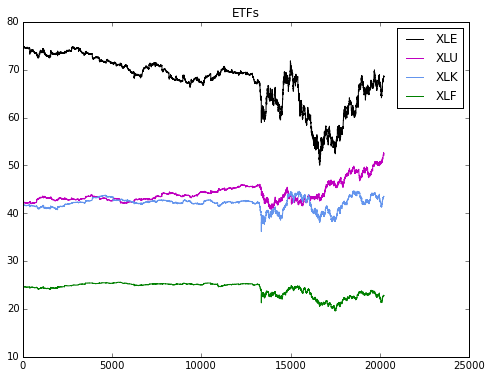

In [337]:
plt.figure(1, figsize=(8,6))

plt.title('ETFs')
plt.rc('lines', linewidth=1)

plt.plot(xle_last, c='k', label='XLE')
plt.plot(xlu_last, c='m', label='XLU')
plt.plot(xlk_last, c='cornflowerblue', label='XLK')
plt.plot(xlf_last, c='g', label='XLF')

plt.legend()

Use coint( ) method of statsmodels library is a convenient form od adfuller( ) method.  The latter is more customizable.  Use coint and p-value returned from it for now.

To compute $coint(X,Y)$ we choose $X$ and $Y$ to be time series 
$$X = \{ x[i], x[i+1],\ \dots ,\ x[i + window-1] \} $$ 
$$Y = \{ y[i], y[i+1],\ \dots ,\ y[i + window-1] \} $$
where $i$ ranges from chosen $\texttt{start_time}$

In [ ]:
def find_coint_pvalue(window, onset, data1, data2):
    # second returned from coint is p-value
    result = coint(data1.loc[onset:onset+window], data2.loc[onset:onset+window])
    return result[1]

start_time = 10000
L = xlk_last.shape[0]

We note that start_time = 10000 corresponds to

In [383]:
print xl['Date'].loc[10000]
print xl[' Time'].loc[10000]

2015-08-07 00:00:00
 17:41:00


We vary different observation window size:

In [ ]:
#observation windows : roughly, 1 day, 1 week, 2 weeks, 1 month
obs_windows = [420, 2010, 4020, 8040] 

In [321]:
def create_pvals(obs_win, data1, data2):
    pvals = []
   
    for onset in range(start_time, L-obs_win):
        if L-obs_win < start_time:
            raise Exception('start_time too close to the end.')
            
        new = find_coint_pvalue(obs_win, onset, data1, data2)
        pvals.append(new)
            
    return pvals

pvals_d = pd.Series(create_pvals(obs_windows[0], xlk_last, xlf_last))
pvals_w = pd.Series(create_pvals(obs_windows[1], xlk_last, xlf_last))
pvals_b = pd.Series(create_pvals(obs_windows[2], xlk_last, xlf_last))
pvals_m = pd.Series(create_pvals(obs_windows[3], xlk_last, xlf_last))

When we choose observation window to be daily, weekly, bi-weekly, monthly, we calculate the following number of p-values:

In [342]:
print pvals_d.shape[0]
print pvals_w.shape[0]
print pvals_b.shape[0]
print pvals_m.shape[0]

9804
8214
6204
2184


We choose significance level to be 5%. Inspect percentage of p-values qualified for cointegration:

In [380]:
sig_level = 0.05

c_d = len(pvals_d[pvals_d<sig_level])/float(pvals_d.shape[0]) * 100.0
c_w = len(pvals_w[pvals_w<sig_level])/float(pvals_w.shape[0]) * 100.0
c_b = len(pvals_b[pvals_b<sig_level])/float(pvals_b.shape[0]) * 100.0
c_m = len(pvals_m[pvals_m<sig_level])/float(pvals_m.shape[0]) * 100.0

print 'observation window is daily, p-value qualifying for co-integration happens {0:.2f}% of time' . format(c_d)
print 'observation window is weekly, p-value qualifying for co-integration happens {0:.2f}% of time' . format(c_w)
print 'observation window is bi-weekly, p-value qualifying for co-integration happens {0:.2f}% of time' . format(c_b)
print 'observation window is monthly, p-value qualifying for co-integration happens {0:.2f}% of time' . format(c_m)


observation window is daily, p-value qualifying for co-integration happens 13.18% of time
observation window is weekly, p-value qualifying for co-integration happens 15.38% of time
observation window is bi-weekly, p-value qualifying for co-integration happens 0.58% of time
observation window is monthly, p-value qualifying for co-integration happens 0.00% of time


At a blue dot, we can conclude that XLK and XLF are cointegrated during subsequent day.
We scatter plot how blue dots are distributed.  XLK and XLF were not chosen carefully, but cointegrated
period happens in "bunch" meaning "cointegration occurs persitantly.  

(10000, 20224)

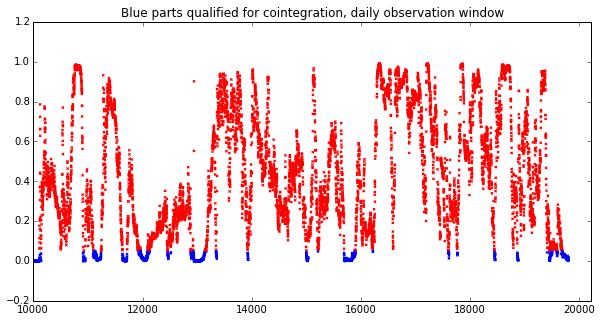

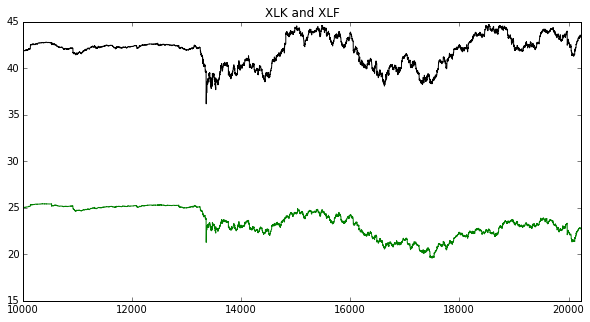

In [387]:
plt.figure(1, figsize=(10,5))

color = np.repeat('b', len(pvals_d))

for i in range(len(color)):
    if pvals_d[i]>sig_level:
        color[i]='r'
        
plt.title('Blue parts qualified for cointegration, daily observation window')
plt.scatter(range(start_time, start_time+len(pvals_d)), pvals_d, s=5, c=color, marker='x')
plt.xlim([start_time, len(xlk_last)])

plt.figure(2, figsize=(10,5))

plt.title('XLK and XLF')
plt.rc('lines', linewidth=1)

plt.plot(xlk_last, c='k', label='XLK')
plt.plot(xlf_last, c='g', label='XLF')

plt.xlim([start_time, len(xlk_last)])
#plt.legend()


(10000, 20224)

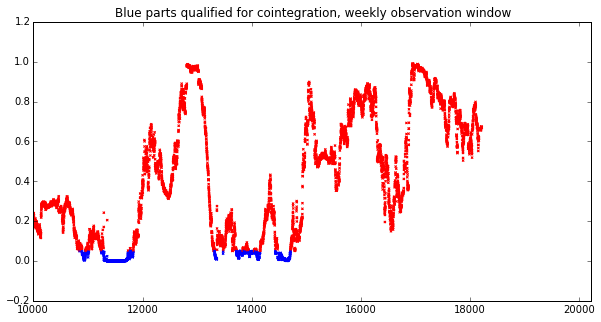

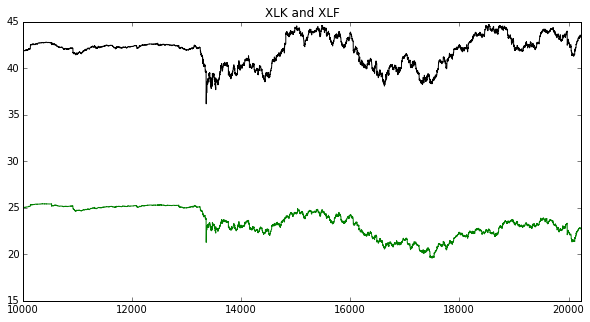

In [389]:
plt.figure(1, figsize=(10,5))

color_w = np.repeat('b', len(pvals_w))

for i in range(len(color_w)):
    if pvals_w[i]>sig_level:
        color_w[i]='r'
        
plt.title('Blue parts qualified for cointegration, weekly observation window')
plt.scatter(range(start_time, start_time+len(pvals_w)), pvals_w, s=5, c=color_w, marker='x')
plt.xlim([start_time, len(xlk_last)])

plt.figure(2, figsize=(10,5))

plt.title('XLK and XLF')
plt.rc('lines', linewidth=1)

plt.plot(xlk_last, c='k', label='XLK')
plt.plot(xlf_last, c='g', label='XLF')

plt.xlim([start_time, len(xlk_last)])

### Correlation

Correlation is not always useful in choosing a pair candidate.

In [401]:
print xlf_last.corr(xlk_last)

0.530707265987


#### Example (highly correlated but a bad pair candidate)

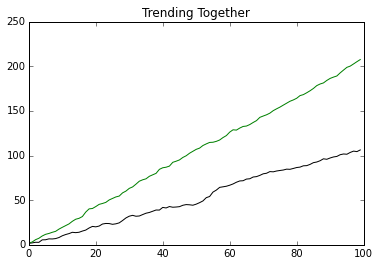

In [403]:
A_returns = np.random.normal(1, 1, 100)
B_returns = np.random.normal(2, 1, 100)

A = pd.Series(np.cumsum(A_returns), name='A')
B = pd.Series(np.cumsum(B_returns), name='B')

plt.title('Trending Together')
plt.plot(A, c='k')
plt.plot(B, c='g')

A and B trend togther and almost perfectly correlated.  But it's difference is diverging, making it a poor choice to find stationary for mean reverting behaviour. 

In [400]:
print 'Correlation: ' + str(A.corr(B))

Correlation: 0.991745963123


## TODO

- It is not clear if there is a systematic way to choose an observation window, other than ad-hoc experiment. We can consider making a widget we can experiment with various observation windows, to see how cointegration points (blue dots) are distributed.  Ultimately, we have to experiment thru test trading.

- Use zipline library to backtesting trades, and simulate a performance

- Working with loaded data is faster than Quantopian research platform.  But it is not fast by any means for large data.    

- If we want a more systematic approach, we can consider Bayesian or Information Theory approach: this method is in fact used in implementing ADF test.

- Investigate Orstein-Uhlenbeck model for speed of mean reversion.  This will guide us for triggering trades: when a cointegrated pair is found, what should be a critical value to triger a trade other than p-value or z
